In [94]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt 

def detect_duplicates(List_patient):
    #Total row of List_patient:
    tot_row_patient = List_patient.patient_id.count()
    print("Total of row on table patient: ", tot_row_patient)
    
    List_patient2 = List_patient.dropna(subset=['state', 'age'])
    List_patient2 = List_patient2.drop(columns=['given_name', 'surname', 
                                   'street_number', 'address_1', 'suburb', 'phone_number',
                                  'address_2'])
    
    #delete all rows when age == 0.00
    age_zero = List_patient2[List_patient2['age'] == 0.00].index
    List_patient2.drop(age_zero, inplace=True)
    
    tot_row_patient2 = List_patient2.patient_id.count()
    print("Total of row on table patient after the process: ", tot_row_patient2)
    
    #How many deleted data's ?
    delete_row = ((tot_row_patient - tot_row_patient2)/tot_row_patient) * 100
    print("To deduplicated, there is: ", delete_row, " % of row, which are deleted")
    
    return List_patient2
    
engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()


In [95]:
print(df_patient.head(20))
print(df_patient.tail(20))

    patient_id given_name      surname  street_number              address_1  \
0       221958    matisse       clarke           13.0            rene street   
1       771155     joshua       elrick           23.0           andrea place   
2       231932      alice       conboy           35.0       mountain circuit   
3       465838     sienna     craswell           39.0    cumberlegeicrescent   
4       359178     joshua    bastiaans          144.0          lowrie street   
5       744167         ky        laing          448.0            nyawi place   
6       210268    matthew        laing           11.0           barnes place   
7       832180       jack      renfrey           27.0          osmand street   
8       154886      adele         ryan           76.0          house circuit   
9       237337   breeanne        wynne           12.0          cowper street   
10      621430    michael        white           17.0          farrer street   
11      187498       None        mason  

In [96]:
#Analyse de la base de données ---------------
 #Il y a 20000 lignes dans la tables "patient", par exemple la colonne given_name a 19560 lignes 
 #rempli. Et le reste des lignes n'ont pas de valeurs. Cette logique s'applique sur les autres
 #colonnes. Le problème c'est qu'il y a des valeurs NaN (cela veut dire qu'il y a des valeur vide dans la colonne) 
 #sur la colonne age et qui genera les statistiques sur les patients par rapport à leur ages. De plus, il y a des ages, 
 #dont la valeur minimum est de 0, ce qui n'est pas possible. 
 #C'est aussi pareil pour les autres colonnes tel que la colonne state, car il y a aussi des valeurs NaN et
 #donc genera les statistiques des patients atteint du covid-19 sur leur zone géographique.
 #En ce qui concerne la table test, il y a 8800 lignes avec aucune valeurs NaN ou None.
 #De plus, il y a des ages, dont la valeur minimum est de 0, ce qui n'est pas possible.   

#Il y a des problèmes de cohérance de données, car dans la requête ci-dessous:
 #data_consistancy = pd.read_sql('select count(*) from patient where patient_id IN (select patient_id from test)', con=con)
 #Les 2 tables sont liées entre un champs commun patient_id. Il y n'y a que 8898 ligne de la table patient qui sont
 #relié avec la table test, cela veut aussi dire qu'il y a 11102 patients dont ont ne connait pas les résultats des tests.
 #Donc il y a plus de 50% des données de la tables patients qui ne sont pas exploitable.

print(df_patient.describe(include="all"))

           patient_id given_name surname  street_number          address_1  \
count    20000.000000      19560   19575   19618.000000              19204   
unique            NaN       1171    4273            NaN               4326   
top               NaN     emiily   white            NaN  paul coe crescent   
freq              NaN        373     539            NaN                 57   
mean    553918.938750        NaN     NaN      98.812468                NaN   
std     260234.961111        NaN     NaN    2481.908686                NaN   
min     100005.000000        NaN     NaN       0.000000                NaN   
25%     330194.250000        NaN     NaN      10.000000                NaN   
50%     556327.500000        NaN     NaN      24.000000                NaN   
75%     779419.500000        NaN     NaN      60.000000                NaN   
max     999993.000000        NaN     NaN  342951.000000                NaN   

           suburb postcode  state  date_of_birth           age 

In [97]:
#Analyse de la base de données suite ---------------
 #Après la déduplication, seulement les colonnes utiles ont été gardés.
 #Nous pouvons remarquer des valeur plus cohérente à l'age. La valeur minimal est 1 an et l'age maximal est de 92 ans. 
 #Dans mon analyse, je suposse que les enfant de 12 mois ne peuvent être testés, de plus, la veleur 0 an de age 
 #fausserait le resultat dans les calcul de moyenne et dans la visualisation des donées.

dedublicated_patient = detect_duplicates(df_patient)
print(dedublicated_patient.describe(include="all"))

Total of row on table patient:  20000
Total of row on table patient after the process:  14393
To deduplicated, there is:  28.035  % of row, which are deleted
           patient_id postcode  state  date_of_birth           age  \
count    14393.000000    14244  14393   1.294600e+04  14393.000000   
unique            NaN     1870     85            NaN           NaN   
top               NaN     4350    nsw            NaN           NaN   
freq              NaN       63   4970            NaN           NaN   
mean    555575.859862      NaN    NaN   1.949840e+07     27.518308   
std     260143.152566      NaN    NaN   2.947453e+05      7.802655   
min     100005.000000      NaN    NaN   1.290041e+07      1.000000   
25%     332050.000000      NaN    NaN   1.925013e+07     24.000000   
50%     557373.000000      NaN    NaN   1.950097e+07     29.000000   
75%     782465.000000      NaN    NaN   1.975062e+07     33.000000   
max     999993.000000      NaN    NaN   1.999123e+07     92.000000   

 

In [108]:
#Below, this a merge between patient and pcr
df_inner = pd.merge(dedublicated_patient, df_pcr, on='patient_id', how='inner')
print(df_inner)

      patient_id postcode state  date_of_birth   age number_state       pcr
0         771155     2074   nsw     19120921.0  34.0         None  Negative
1         744167     3556   qld     19050919.0  32.0         None         N
2         210268     2160   nsw     19061018.0  29.0         None  Negative
3         832180     2170   qld     19610518.0  31.0         None         P
4         154886     2200   qld     19430102.0  33.0         None  Negative
...          ...      ...   ...            ...   ...          ...       ...
6445      230775     2388   nsw     19491217.0  30.0         None         P
6446      407822     3174   nsw     19241001.0  25.0         None  Negative
6447      704579     2604   vic     19140808.0   7.0         None  Positive
6448      329489     2578   vic     19720229.0  25.0         None  Positive
6449      506906     3149   qld     19211111.0  34.0         None         N

[6450 rows x 7 columns]


In [103]:
#Analyse des résultats -------------------------------------
 #Nombre de cas positives:
 #Via la dataset dédupliqué, nous avons 1621 cas positive récensé avec fiabilité, puisque 
 #lignes dont l'age est égale à 0 ou NaN, ou dont la valeur de state est à NaN.
 #Mais cela peut aussi dire qu'une ligne avec une age valide, alors que le state est à NaN
 #sera supprimé. Cependant, si une ce ligne sans state a été accepté, alors cela fauserai la visualisation
 #des données avec l'age.
    
#Pour trouver le nombre de cas positive (les valeurs sont 'Positive' ou 'P')
positive_people = df_inner.query('pcr == "Positive" or pcr == "P"').patient_id.count()
print("Number of positif case: ", positive_people)

#Ci-dessous, permet de voir ce que représente 1621 cas positive sur le nombre tatal de patient avant la déduplication 
perc_positive = (int(positive_people)/20000)*100
print("Total of positive people is: ", perc_positive, "%")

#Ci-dessous, permet de voir ce que représente 1621 cas positive sur le nombre tatal de patient après la déduplication 
perc_positive_dedub = (int(positive_people)/14393)*100
print("Total of positive people in deduplicated data is: ", perc_positive_dedub, "%")

Number of positif case:  1621
Total of positive people is:  8.105 %
Total of positive people in deduplicated data is:  11.262419231570902 %


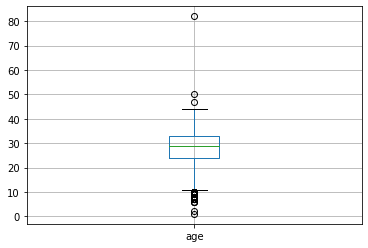

In [99]:
#Analyse des résultats suite -------------------------------------
 #Dans notre base de données, nous pouvons voir que la majorité de la population de la base de données
 #sont dans la tranche de 20-40 ans (Même en comptant les 1er et le 3eme quartiles).
 #Cela veut dire que la base de données n'ont pas une populations très hétérogène, car les patients
 #testés sont relativement jeune.

boxplot = df_inner.boxplot(column=['age'])

Text(0.5, 1.0, 'Ratio age et nombre de personne')

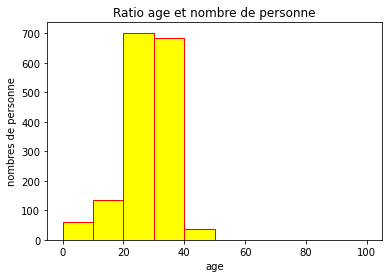

In [100]:
#Analyse des résultats suite -------------------------------------
 #L'histogramme ci-dessous confirme le graphique précédent. Cela vut dire que la majorité de la
 #population se trouve dans la tranche 20 - 40 ans. Surtout dans la permière moitié.

plt.hist(df_inner.age, range = (0, 100), bins = 10, color = 'yellow',
            edgecolor = 'red')
plt.xlabel('age')
plt.ylabel('nombres de personne')
plt.title('Ratio age et nombre de personne')

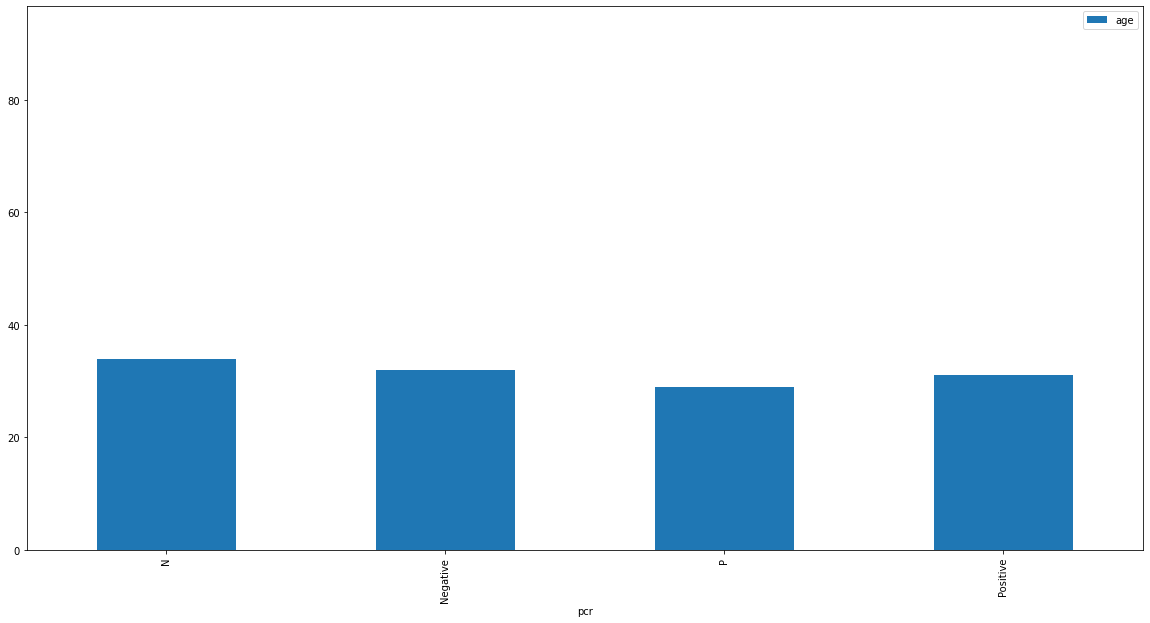

In [104]:
#Analyse des résultats suite -------------------------------------
 #Ci-dessous, nous avons un histogramme sur le ratio age et résultat. La majorité des
 #cas positives sont dans les 40 ans. C'est -à-dire que les popultations entre 0 -20 ans et 20 - 40 sont plus de
 #chance d'être positive. Cependant, la majourité de la population sont entre
 #0 - 40 ans, pour avoir des résultats plus fiable, il faut des ages plus différents (surtout au-dessus de 40 ans).

df_inner.plot(kind='bar',x='pcr',y='age')
df_inner.groupby('pcr')['pcr'].nunique().plot(kind='bar', figsize=(20,10))
plt.show()

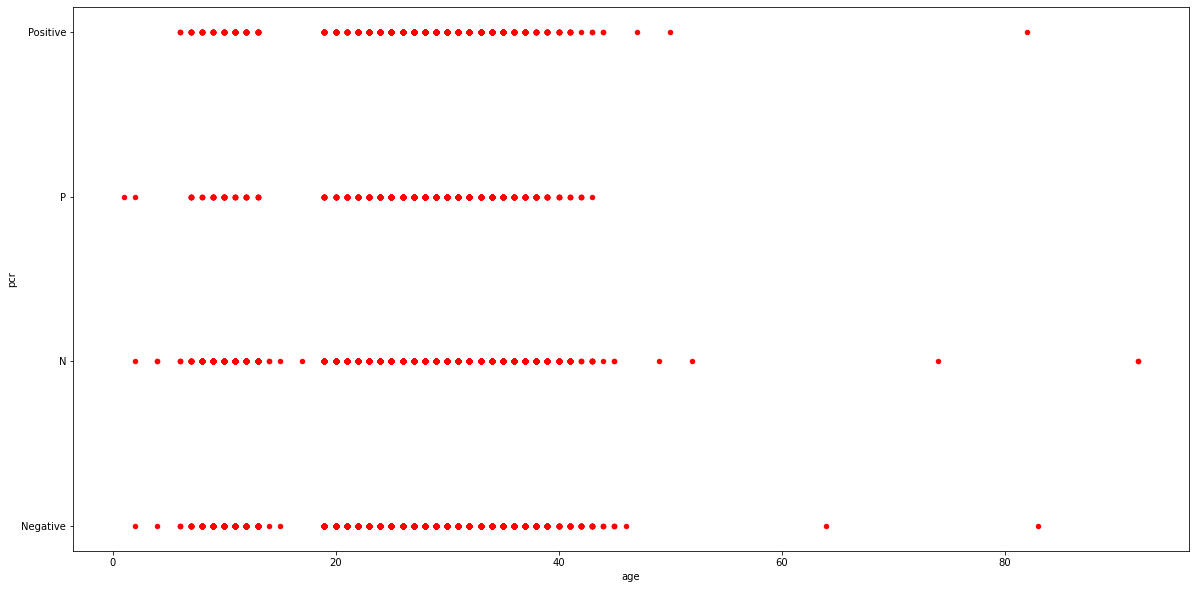

In [109]:
#Analyse des résultats suite -------------------------------------
 #Ci-dessous, nous avons un graphe qui montre avec plus de précision la relation avec l'age de
 #la population et le virus. Le graphe précedent, nous a fait comprendre que les atteeint du virus
 #sont dans la population jeune (0 - 40 ans). Mais ci-dessous, il nous précise que ce sont les personnes 
 #entre 20 - 40 qui sont les plus touchées. Mais nous pouvons aussi remarqué que des personnes avec des ages
 #plus avancées de notre population sont assez epargnées du virus, comme indiquer sur la ligne 3 et 4 du graphe ci-dessous.
 #Mais cela ne veut pas dire que le virus n'a pas d'effet sur les personnes agées,  puisque qu'il faut voir la ligne 1
 #du graphe ci-dessous. 
    
 #Les graphes précédents nous montraient que notre population en base de données sont principalement constituées
 #de personne e,tre 0 - 40 ans. Dans pour confirner l'analyse entre l'age d'une personnes et le virus, il faut plus de 
 #données concernant les personnes entre 40 - 80 ans.
    
#Below indicated the ratio between age et pcr
df_inner.plot(kind='scatter',x='age',y='pcr',color='red', figsize=(20,10))
plt.show()

    patient_id postcode state  date_of_birth   age number_state       pcr
3       832180     2170   qld     19610518.0  31.0         None         P
5       999159     7004   nsw     19650125.0  33.0         None  Positive
9       335796     4575   act     19481205.0  24.0         None         P
12      484681     2317   vic     19130421.0  28.0         None  Positive
13      754811     4075   tas     19611127.0  33.0         None  Positive
14      419030     2303   qld     19890823.0  20.0         None  Positive
19      431236     7301   qld     19380506.0   8.0         None  Positive
27      356508     7277   qld     19600624.0  35.0         None         P
31      824839     4118    wa     19011122.0  24.0         None  Positive
32      415139     2428   qld            NaN  21.0         None         P
37      587879     None   vic     19351020.0  26.0         None  Positive
39      124300     2045   nsw     19770703.0  26.0         None  Positive
40      448951     7250   nsw     1974

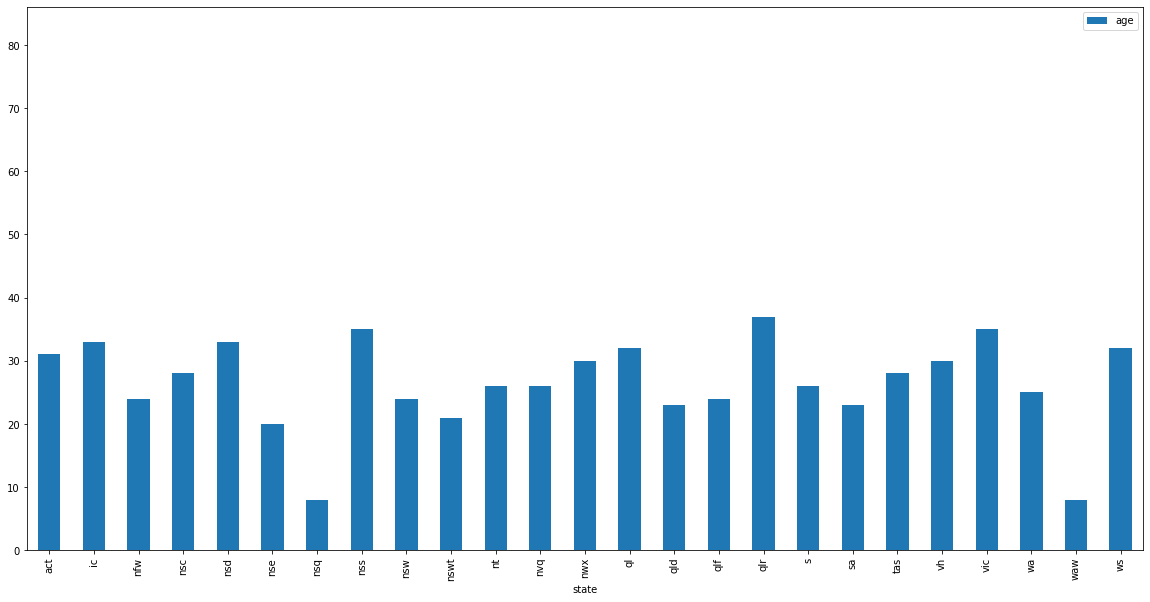

In [106]:
#Analyse des résultats suite -------------------------------------
 #ci-dessous, ce sont les résultats d'un ratio entre age et les états du pays.
 #Ce ratio a été crée à partir d'une population où il n'y a que des cas positives.
 
List_positive_case = df_inner

no_positive = List_positive_case[(List_positive_case['pcr'] == 'Negative') | (List_positive_case['pcr'] == 'N')].index
List_positive_case.drop(no_positive, inplace=True)
    
print(List_positive_case.head(20))

List_positive_case.plot(kind='bar',x='state',y='age')
List_positive_case.groupby('state')['state'].nunique().plot(kind='bar', figsize=(20,10))
plt.show()

In [111]:
#Nous pouvons donc voir que état "nsw", "qld", "sa", "vic" et "wa"
 #qui sont plus sérieusement touché par le virus, car ont plus de cas positive.
print(List_positive_case.groupby('state').patient_id.count())

state
act      20
ic        1
nfw       1
nsc       1
nsd       1
nse       1
nsq       1
nss       4
nsw     539
nswt      1
nt        5
nvq       1
nwx       1
ql        1
qld     321
qlf       1
qlr       1
s         1
sa      110
tas      47
vh        1
vic     409
wa      148
waw       1
ws        3
Name: patient_id, dtype: int64


In [112]:
#Analyse Finale -----------------------------------------
 #De ce que nous pouvons voir au début du projet, la base de données comporté des champs vides, ainsi quelque problème
 #de cohérence de données. C'est à dire qu'il y a des ligne où la valeur age était égale à 0. De plus, il y avait des cas où
 #des lignes où il n'y avais pas de valeur pour les états. Du coup, pour avoir des données fiable à réaliser, il faut supprimer
 #tous les lignes à problème. Du coup, notre nouveau jeu de données à analyser contient 28% de moins de données par apport
 #à notre jeu initial. Nous avons pu voir au cours de toute notre analyse que les personnes entre 0 à 40 ans de notre
 #popultation (les patients en base de donnée) sont plus atteint par le virus. Ensuite, les graphes ont pu montrer quelles 
 #étaient les zones géographiques les plus touchées par le virus. Cependant, notre analyse a un prblème, car notre 
 #population est principalement consitutée de population jeune (dans les 40 ans), du coup il faut plus de jeun de données et
 #avec des ages plus hétérogène pour réaliser une analyse fiable entre l'age d'une personne et le virus.